In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#we need to install java for mallet to work
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.15" 2022-04-19
OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1)
OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip      #the mallet file needed
!unzip mallet-2.0.8.zip

In [ ]:
pip install pyLDAvis

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
sns.set()

# nltk
import nltk 
nltk.download('stopwords')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [6]:
df = pd.read_csv("/content/drive/MyDrive/okcupid/okcupid_profiles.csv")

In [7]:
bios = df[["essay0"]].dropna() #get essay0 and dropna

In [9]:
#just focusing on the essay0 since that is the most answered question from 60k profiles and it's their main bio
data = bios.essay0.values.tolist() #convert to list for gensim use

In [10]:
#make bigram and trigram model
bigram = gensim.models.Phrases(data, min_count=20, threshold=100)
trigram = gensim.models.Phrases(bigram[data], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [11]:
# only need tagger, no need for parser and named entity recognizer, for faster implementation
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# get stopwords from nltk library
stop_words = nltk.corpus.stopwords.words('english')

def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    """Convert a document into a list of lowercase tokens, build bigrams-trigrams, implement lemmatization"""
    
    # remove stopwords, short tokens and letter accents 
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    
    # bi-gram and tri-gram implementation
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out

In [12]:
data_ready = process_words(data)

In [13]:
# create a dictionary, the model requires a dictionary and corpus to process
id2word = corpora.Dictionary(data_ready) # contains all the words and numerical identifiers one for each unique word
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 43205


In [14]:
corpus = [id2word.doc2bow(text) for text in data_ready] # a list of lists containing tuples for each word id and its frequency

In [15]:
# create a dictionary and then convert it to a dataframe that shows each word in the corpus and its frequency
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


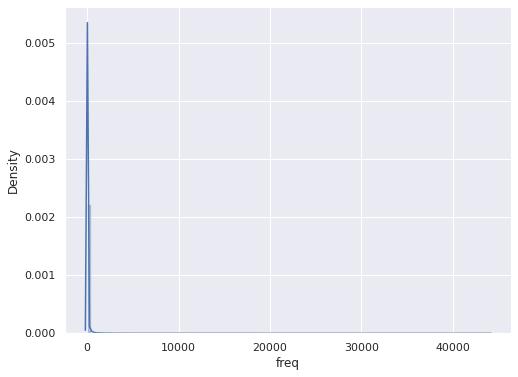

In [ ]:
plt.figure(figsize=(8,6))
sns.distplot(dict_df['freq'], bins=100);

In [16]:
dict_df.sort_values('freq', ascending=False).head(10)

,freq
love,52900
life,28987
people,26882
good,26262
time,25715
thing,25701
get,24817
friend,21670
enjoy,20890
new,19996


In [17]:
# Filter out words that occur less than 10 documents, or more than
# 50% of the documents.
id2word.filter_extremes(no_below=10, no_above=0.5)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 9496


In [18]:
# Create Corpus: Term Document Frequency after reducing from 39899 to 8682
corpus = [id2word.doc2bow(text) for text in data_ready]

In [19]:
# For mallet
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [42]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [43]:
from pprint import pprint
# display topics
pprint(ldamallet.show_topics(formatted=False))

[(12,
  [('play', 0.07247121810228606),
   ('watch', 0.06053170130840034),
   ('movie', 0.05701095021483371),
   ('love', 0.048398203738009564),
   ('game', 0.048378805660359056),
   ('sport', 0.04227811023927529),
   ('enjoy', 0.03143458483264309),
   ('fan', 0.020755943086040174),
   ('big', 0.01700241506066749),
   ('video', 0.015673646741607906)]),
 (2,
  [('love', 0.16913130926156497),
   ('music', 0.10716406474475625),
   ('dance', 0.04505315582798582),
   ('listen', 0.026022411646394024),
   ('play', 0.025581840819844843),
   ('live', 0.021224020687673595),
   ('food', 0.018542285221722056),
   ('art', 0.017153529355425724),
   ('dancing', 0.015659419595824155),
   ('read', 0.014663346422756442)]),
 (14,
  [('relationship', 0.05174101164108375),
   ('man', 0.04780055629957763),
   ('woman', 0.044461041859826245),
   ('long', 0.02769479070086879),
   ('date', 0.0210758559115415),
   ('open', 0.020886988770990007),
   ('partner', 0.020620857800212906),
   ('interested', 0.01876652

In [44]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score: ', coherence_ldamallet)

Coherence Score:  0.4494274148325326


In [58]:
import pickle
pickle.dump(ldamallet, open("drive/My Drive/new_model_20topics_7_26.pkl", "wb"))
# load pickle
# ldamallet = pickle.load(open("drive/My Drive/ldamallet.pkl", "rb"))

In [59]:
 # load pickle
ldamallet = pickle.load(open("drive/My Drive/new_model_20topics_7_26.pkl", "rb"))

In [48]:
# topic modeling results (distribution of topics for each document) 
tm_results = ldamallet[corpus]

In [49]:
ldamallet[corpus[0]] 

[(0, 0.03497942386831276),
 (1, 0.029218106995884775),
 (2, 0.03168724279835391),
 (3, 0.04238683127572016),
 (4, 0.021810699588477367),
 (5, 0.14279835390946502),
 (6, 0.028395061728395062),
 (7, 0.10576131687242799),
 (8, 0.025925925925925925),
 (9, 0.11728395061728394),
 (10, 0.05555555555555555),
 (11, 0.03333333333333333),
 (12, 0.04814814814814815),
 (13, 0.025102880658436213),
 (14, 0.026748971193415638),
 (15, 0.09506172839506173),
 (16, 0.02263374485596708),
 (17, 0.03580246913580247),
 (18, 0.05555555555555555),
 (19, 0.021810699588477367)]

In [50]:
# get the most dominant topic of each document
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

In [51]:
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=20)] for n in range(0, ldamallet.num_topics)]


In [52]:
# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )
topics_df
#6,8,10,11,16,19

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Terms per Topic
Topic1,"thing, make, lot, day, pretty, bit, time, good, awesome, stuff, big, long, random, bad, start, crazy, story, part, list, super"
Topic2,"work, life, time, hard, family, friend, live, kid, spend, job, day, part, full, career, goal, close, important, year, child, young"
Topic3,"love, music, dance, listen, play, live, food, art, dancing, read, rock, show, learn, favorite, cook, band, eat, theater, sing, walk"
Topic4,"guy, fun, pretty, girl, person, nice, easy, friend, meet, good, lay, type, earth, kind, outgoing, simple, funny, cool, hang, shy"
Topic5,"love, travel, live, place, explore, city, world, adventure, life, experience, great, country, amazing, find, offer, culture, visit, learn, food, discover"
Topic6,"eat, dog, wear, coffee, drink, cat, day, sleep, walk, animal, hot, morning, dress, car, hair, night, hand, eye, color, beer"
Topic7,"work, art, make, thing, creative, artist, design, book, write, car, small, build, project, film, draw, company, stuff, photography, lot, dream"
Topic8,"leave, call, turn, order, break, lose, fact, human, end, point, story, die, result, number, high, tend, brain, speak, form, save"
Topic9,"year, move, live, back, grow, bear, area, school, raise, ago, recently, college, coast, city, originally, month, bay, graduate, job, spend"
Topic10,"write, profile, read, message, word, date, question, talk, site, hate, online, give, summary, time, picture, guess, put, fill, start, answer"


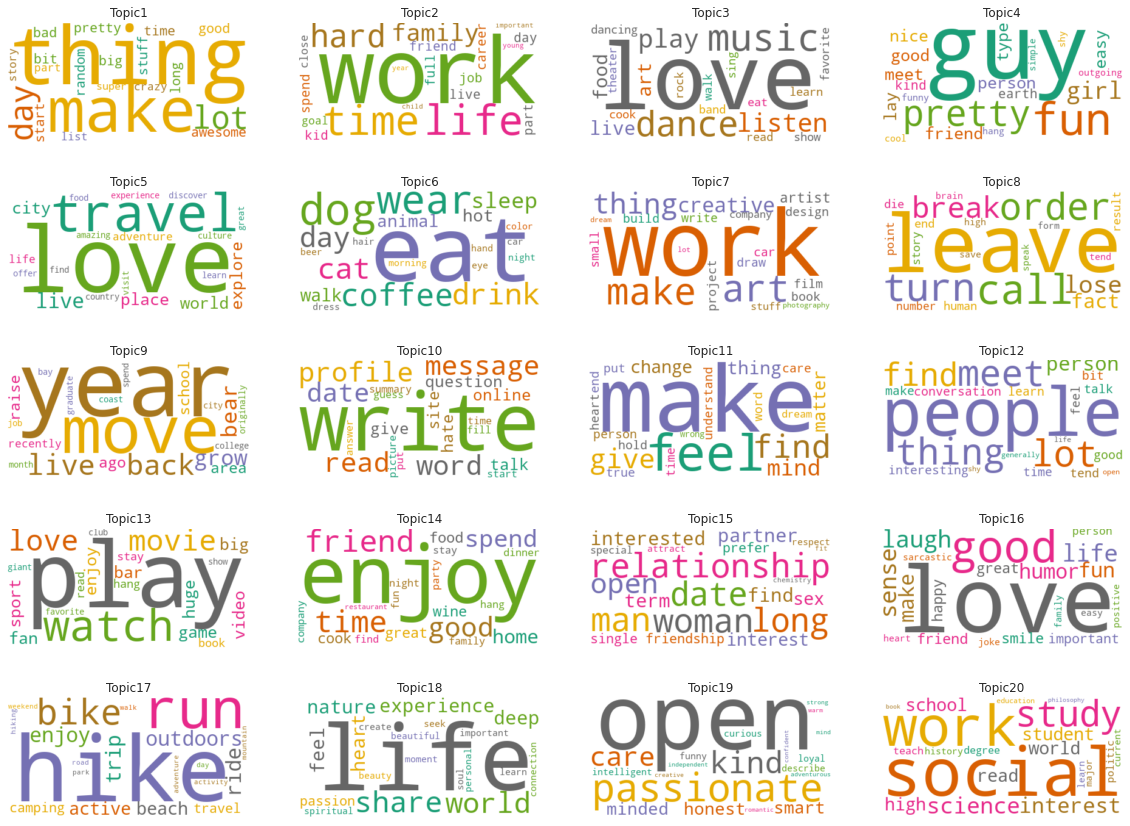

In [54]:
# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(20):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()
#6,8,10,11,16,19

In [29]:
# viz by pyLDAvis
from gensim.models.ldamodel import LdaModel

def convertldaMalletToldaGen(mallet_model): #convert ldamallet to LDA
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [56]:
ldagensim = convertldaMalletToldaGen(ldamallet)

In [57]:
import pyLDAvis.gensim_models as gensimvis
vis_data = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldagensim, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.2197,"make, hand, car, dog, wear, day, walk, girl, cat, eat","about me: i would love to think that i was some some kind of intellectual: either the dumbest smart guy, or the smartest dumb guy. can't say i can tell the difference. i love to talk about ideas and concepts. i forge odd metaphors instead of reciting cliches. like the simularities between a friend of mine's house and an underwater salt mine. my favorite word is salt by the way (weird choice i know). to me most things in life are better as metaphors. i seek to make myself a little better everyday, in some productively lazy way. got tired of tying my shoes. considered hiring a five year old, but would probably have to tie both of our shoes... decided to only wear leather shoes dress shoes. about you: you love to have really serious, really deep conversations about really silly stuff. you have to be willing to snap me out of a light hearted rant with a kiss. you don't have to be funny, but you have to be able to make me laugh. you should be able to bend spoons with your mind, and telepathically make me smile while i am still at work. you should love life, and be cool with just letting the wind blow. extra points for reading all this and guessing my favorite video game (no hints given yet). and lastly you have a good attention span."
1,1,5.0,0.1611,"enjoy, travel, love, food, hike, run, explore, place, active, bike",i am a chef: this is what that means. 1. i am a workaholic. 2. i love to cook regardless of whether i am at work. 3. i love to drink and eat foods that are probably really bad for me. 4. i love being around people that resemble line 1-3. i love the outdoors and i am an avid skier. if its snowing i will be in tahoe at the very least. i am a very confident and friendly. i'm not interested in acting or being a typical guy. i have no time or patience for rediculous acts of territorial pissing. overall i am a very likable easygoing individual. i am very adventurous and always looking forward to doing new things and hopefully sharing it with the right person.
2,2,8.0,0.2712,"people, date, thing, talk, profile, write, make, word, meet, message","i'm not ashamed of much, but writing public text on an online dating site makes me pleasantly uncomfortable. i'll try to be as earnest as possible in the noble endeavor of standing naked before the world. i've lived in san francisco for 15 years, and both love it and find myself frustrated with its deficits. lots of great friends and acquaintances (which increases my apprehension to put anything on this site), but i'm feeling like meeting some new people that aren't just friends of friends. it's okay if you are a friend of a friend too. chances are, if you make it through the complex filtering process of multiple choice questions, lifestyle statistics, photo scanning, and these indulgent blurbs of text without moving quickly on to another search result, you are probably already a cultural peer and at most 2 people removed. at first, i thought i should say as little as possible here to avoid you, but that seems silly. as far as culture goes, i'm definitely more on the weird side of the spectrum, but i don't exactly wear it on my sleeve. once you get me talking, it will probably become increasingly apparent that while i'd like to think of myself as just like everybody else (and by some definition i certainly am), most people don't see me that way. that's fine with me. most of the people i find myself gravitating towards are pretty weird themselves. you probably are too."
3,3,4.0,0.1154,"year, live, work, move, grow, back, school, city, area, bear",i work in a library and go to school. . .
4,4,8.0,0.1514,"people, date, thing, talk, profile, write, make, word, meet, message","hey how's it going? currently vague on the profile i know, more to come soon. looking to meet new folks outside of my circle of friends. i'm pretty responsive on the reply tip, feel fre

In [20]:
# Finding the optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=7, limit=24, step=3)

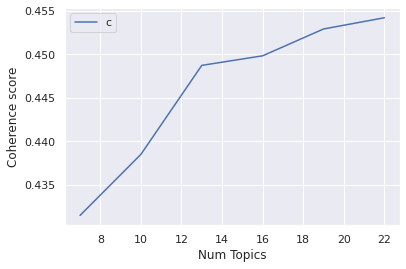

In [25]:
limit=24; start=7; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [26]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 7  has Coherence Value of 0.4315
Num Topics = 10  has Coherence Value of 0.4385
Num Topics = 13  has Coherence Value of 0.4487
Num Topics = 16  has Coherence Value of 0.4498
Num Topics = 19  has Coherence Value of 0.4529
Num Topics = 22  has Coherence Value of 0.4542


In [68]:
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.081*"guy" + 0.080*"fun" + 0.079*"meet" + 0.061*"person" + 0.056*"people" '
  '+ 0.048*"easy" + 0.045*"friend" + 0.041*"pretty" + 0.041*"girl" + '
  '0.039*"nice"'),
 (1,
  '0.071*"work" + 0.045*"school" + 0.041*"year" + 0.022*"college" + '
  '0.019*"start" + 0.017*"job" + 0.017*"grow" + 0.017*"kid" + 0.016*"high" + '
  '0.014*"study"'),
 (2,
  '0.013*"dog" + 0.012*"wear" + 0.011*"cat" + 0.010*"hand" + 0.009*"eye" + '
  '0.009*"hot" + 0.009*"dress" + 0.008*"hair" + 0.008*"car" + 0.008*"eat"'),
 (3,
  '0.119*"life" + 0.072*"friend" + 0.068*"love" + 0.060*"family" + '
  '0.059*"good" + 0.056*"great" + 0.046*"humor" + 0.043*"laugh" + '
  '0.042*"sense" + 0.041*"enjoy"'),
 (4,
  '0.147*"thing" + 0.119*"people" + 0.089*"make" + 0.055*"lot" + '
  '0.037*"pretty" + 0.033*"laugh" + 0.028*"good" + 0.026*"talk" + '
  '0.024*"stuff" + 0.023*"interesting"'),
 (5,
  '0.060*"travel" + 0.058*"enjoy" + 0.042*"hike" + 0.034*"love" + 0.032*"run" '
  '+ 0.032*"active" + 0.032*"bike" + 0.030*"out

In [61]:
# visualiing the optimal model
ldagensim = convertldaMalletToldaGen(optimal_model)

In [62]:
import pyLDAvis.gensim_models as gensimvis
vis_data = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [69]:
# save optimal model
pickle.dump(optimal_model, open("drive/My Drive/optimal_model_19_topic_45score.pkl", "wb"))

In [70]:
# load pickle
model = pickle.load(open("drive/My Drive/optimal_model_19_topic_45score.pkl", "rb"))

In [63]:
tm_results = optimal_model[corpus]

In [64]:
# get the most dominant topic of each document
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

In [65]:
topics = [[(term, round(wt, 3)) for term, wt in optimal_model.show_topic(n, topn=20)] for n in range(0, optimal_model.num_topics)]

In [66]:
optimal_model[corpus[0]] 

[(0, 0.1328843995510662),
 (1, 0.045641601197156746),
 (2, 0.02341937897493453),
 (3, 0.04646464646464646),
 (4, 0.044818555929667034),
 (5, 0.020950243172465393),
 (6, 0.02341937897493453),
 (7, 0.05881032547699214),
 (8, 0.06704077815188926),
 (9, 0.062102506546950986),
 (10, 0.0349420127197905),
 (11, 0.051402918069584726),
 (12, 0.06868686868686869),
 (13, 0.025888514777403664),
 (14, 0.022596333707444818),
 (15, 0.030003741114852225),
 (16, 0.020127197904975684),
 (17, 0.030826786382341934),
 (18, 0.0835016835016835),
 (19, 0.021773288439955105),
 (20, 0.042349420127197904),
 (21, 0.042349420127197904)]

In [67]:
# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, optimal_model.num_topics+1)] )
topics_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Terms per Topic
Topic1,"car, wear, hand, head, dress, hair, eye, black, tall, drive, door, top, make, night, day, foot, high, hold, fall, white"
Topic2,"relationship, open, deep, nature, partner, sex, spiritual, practice, interested, community, seek, connection, feel, personal, term, long, body, social, deeply, human"
Topic3,"time, friend, work, spend, family, enjoy, hard, good, day, lot, close, free, home, stay, hang, important, busy, spending, relax, week"
Topic4,"person, open, fun, love, honest, kind, funny, passionate, minded, care, loyal, easy, adventurous, friend, describe, friendly, smart, outgoing, intelligent, spontaneous"
Topic5,"eat, food, day, dog, drink, coffee, cook, walk, favorite, beer, cat, animal, book, morning, sleep, hot, night, market, hour, shop"
Topic6,"people, meet, find, friend, person, date, time, hope, interested, good, online, give, interesting, great, long, thing, feel, site, interest, forward"
Topic7,"love, travel, place, explore, city, live, enjoy, food, wine, great, restaurant, adventure, country, cook, home, visit, culture, bar, offer, favorite"
Topic8,"thing, people, make, lot, learn, good, feel, talk, pretty, happy, interesting, place, find, awesome, stuff, story, kind, random, happen, idea"
Topic9,"write, read, profile, message, question, summary, word, picture, point, answer, start, put, fill, okcupid, send, add, update, long, photo, note"
Topic10,"make, bad, hate, word, talk, give, fact, call, wrong, point, speak, reason, end, lie, shit, stand, joke, change, turn, real"


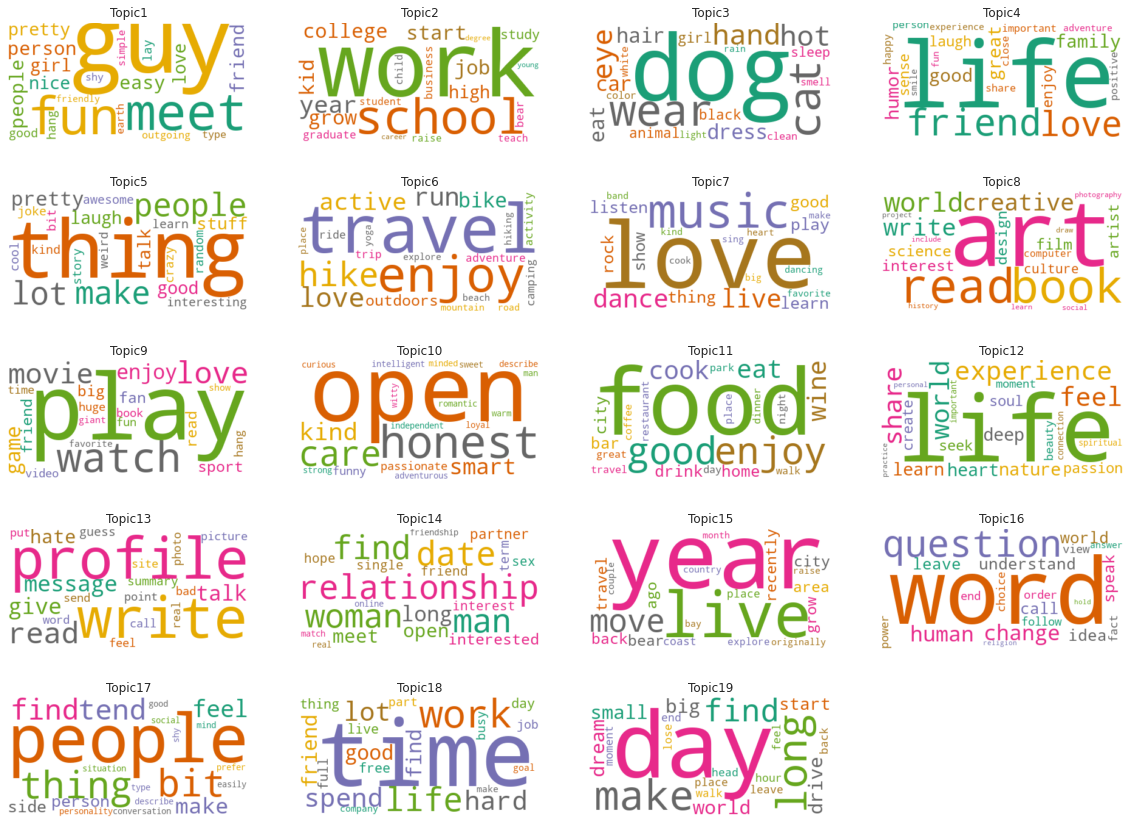

In [41]:
# wordcloud the optimal model

# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(19):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()
#3,5,9,10,13,16

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.1466,"day, dog, car, eat, wear, cat, drive, walk, sleep, coffee","about me: i would love to think that i was some some kind of intellectual: either the dumbest smart guy, or the smartest dumb guy. can't say i can tell the difference. i love to talk about ideas and concepts. i forge odd metaphors instead of reciting cliches. like the simularities between a friend of mine's house and an underwater salt mine. my favorite word is salt by the way (weird choice i know). to me most things in life are better as metaphors. i seek to make myself a little better everyday, in some productively lazy way. got tired of tying my shoes. considered hiring a five year old, but would probably have to tie both of our shoes... decided to only wear leather shoes dress shoes. about you: you love to have really serious, really deep conversations about really silly stuff. you have to be willing to snap me out of a light hearted rant with a kiss. you don't have to be funny, but you have to be able to make me laugh. you should be able to bend spoons with your mind, and telepathically make me smile while i am still at work. you should love life, and be cool with just letting the wind blow. extra points for reading all this and guessing my favorite video game (no hints given yet). and lastly you have a good attention span."
1,1,6.0,0.1087,"travel, enjoy, hike, run, bike, outdoors, food, trip, wine, ride",i am a chef: this is what that means. 1. i am a workaholic. 2. i love to cook regardless of whether i am at work. 3. i love to drink and eat foods that are probably really bad for me. 4. i love being around people that resemble line 1-3. i love the outdoors and i am an avid skier. if its snowing i will be in tahoe at the very least. i am a very confident and friendly. i'm not interested in acting or being a typical guy. i have no time or patience for rediculous acts of territorial pissing. overall i am a very likable easygoing individual. i am very adventurous and always looking forward to doing new things and hopefully sharing it with the right person.
2,2,5.0,0.1743,"date, write, meet, profile, time, read, find, give, message, guy","i'm not ashamed of much, but writing public text on an online dating site makes me pleasantly uncomfortable. i'll try to be as earnest as possible in the noble endeavor of standing naked before the world. i've lived in san francisco for 15 years, and both love it and find myself frustrated with its deficits. lots of great friends and acquaintances (which increases my apprehension to put anything on this site), but i'm feeling like meeting some new people that aren't just friends of friends. it's okay if you are a friend of a friend too. chances are, if you make it through the complex filtering process of multiple choice questions, lifestyle statistics, photo scanning, and these indulgent blurbs of text without moving quickly on to another search result, you are probably already a cultural peer and at most 2 people removed. at first, i thought i should say as little as possible here to avoid you, but that seems silly. as far as culture goes, i'm definitely more on the weird side of the spectrum, but i don't exactly wear it on my sleeve. once you get me talking, it will probably become increasingly apparent that while i'd like to think of myself as just like everybody else (and by some definition i certainly am), most people don't see me that way. that's fine with me. most of the people i find myself gravitating towards are pretty weird themselves. you probably are too."
3,3,8.0,0.0900,"work, school, study, start, learn, high, teach, science, read, business",i work in a library and go to school. . .
4,4,5.0,0.1592,"date, write, meet, profile, time, read, find, give, message, guy","hey how's it going? currently vague on the profile i know, more to come soon. looking to meet new folks outside of my circle of friends. i'm pretty responsive on the reply tip, fee

In [ ]:
corpora.MmCorpus.serialize('/content/drive/MyDrive/gensim_corpus.mm', corpus)

In [ ]:
#Questions for Alec:
#1. The separation of topics in the bubble, im not sure how to interpret the results. 
   #Is it good that they are separated?
#2. Is it good filtering out the extremes on my project and dataset? Basically reducing from 39899 to 8682.